In [34]:
import cartopy.crs as ccrs
from cmocean import cm 
from dino import Experiment
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import cftime as cft
import xnemogcm as xn
import xgcm
from xesmf import Regridder

In [2]:
path   = "/data/dkamm/nemo_output/DINO/"
dino_exp = Experiment(path, 'HigherRidgeEmP/restart40')

In [7]:
dino_exp_vol = Experiment(path, 'GetVolLR')

In [38]:
emp_self = xr.open_dataset(path + 'HigherRidgeEmP/restart40/emp_climatology.nc').rename({'x':'x_c', 'y':'y_c'}).assign_coords({'lat':dino_exp.domain.gphit, 'lon':dino_exp.domain.glamt}).drop_vars(['glamt','gphit'])

In [39]:
emp_self

<xarray.Dataset>
Dimensions:  (t: 360, y_c: 199, x_c: 60)
Coordinates:
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 ... 191 192 193 194 195 196 197 198
    lat      (y_c, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
    lon      (y_c, x_c) float64 dask.array<chunksize=(17, 20), meta=np.ndarray>
Dimensions without coordinates: t
Data variables:
    emp      (t, y_c, x_c) float64 ...

In [40]:
emp_dummy = dino_exp_vol.domain.e1t.rename({'gphit':'lat', 'glamt':'lon'})

In [46]:
emp_dummy

<xarray.Dataset>
Dimensions:  (y_c: 199, x_c: 62)
Coordinates:
    lon      (y_c, x_c) float64 dask.array<chunksize=(17, 21), meta=np.ndarray>
    lat      (y_c, x_c) float64 dask.array<chunksize=(17, 21), meta=np.ndarray>
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60 61
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 ... 191 192 193 194 195 196 197 198
Data variables:
    e1t      (y_c, x_c) float64 dask.array<chunksize=(17, 21), meta=np.ndarray>

In [49]:
test = Regridder(emp_self, emp_dummy, method='nearest_s2d')

In [9]:
test = dino_exp.regrid_restart(dino_exp_vol)

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [58]:
test(emp_self).isel(t=-1, y_c=100).emp.values

array([            nan, -7.03140959e-05, -6.69362821e-05, -6.53175619e-05,
       -5.77151427e-05, -5.19190839e-05, -4.96236950e-05, -4.68909221e-05,
       -4.58103576e-05, -4.52709490e-05, -4.48209281e-05, -4.44606533e-05,
       -4.41364370e-05, -4.38584663e-05, -4.35721995e-05, -4.32161185e-05,
       -4.28010583e-05, -4.22207293e-05, -4.18043456e-05, -4.13339444e-05,
       -4.11729583e-05, -4.06938045e-05, -4.02492995e-05, -3.97370601e-05,
       -3.92004342e-05, -3.85928881e-05, -3.79208927e-05, -3.72864154e-05,
       -3.66207802e-05, -3.62753614e-05, -3.50235711e-05, -3.53106960e-05,
       -3.45440145e-05, -3.46837737e-05, -3.39742161e-05, -3.42557662e-05,
       -3.27511196e-05, -3.33831388e-05, -3.22482647e-05, -3.24579295e-05,
       -3.15834714e-05, -3.15855418e-05, -3.08153893e-05, -3.04069643e-05,
       -2.96664428e-05, -2.89103044e-05, -2.83802478e-05, -2.74881594e-05,
       -2.72966631e-05, -2.64994117e-05, -2.64824519e-05, -2.56125839e-05,
       -2.53086381e-05, -

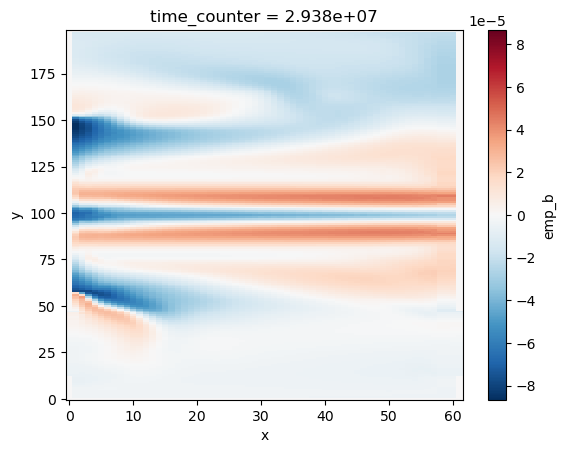

In [12]:
test.emp_b.plot()

In [5]:
dino_exp.regrid_restart?

Signature: dino_exp.regrid_restart(other)
Docstring: Regridding a restart file to the horizontal resolution of another. 
File:      ~/dino-analysis/dino.py
Type:      method
